# Baseball Statistics

Baseball is a game full of statistics, and most of those statistics have been consistently and carefully tracked going back to the late 1800s. That makes professional baseball a playground for data analysts. Here I look at interesting correlations between players, their stats, and their salaries.

**Data Source:** [Lahman's Baseball Database](http://www.seanlahman.com/baseball-archive/statistics/). The data set I used was through the 2018 season.

Copyright (c) 2019 Ken Norton (ken@kennethnorton.com)

In [1]:
import sys
import logging

import numpy as np
import scipy as sp
import sklearn
import statsmodels.api as sm
from statsmodels.formula.api import ols

%load_ext autoreload
%autoreload 2

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import seaborn as sns
import pandas as pd
pd.set_option("display.max_rows", 120)
pd.set_option("display.max_columns", 120)

logging.basicConfig(level=logging.INFO, stream=sys.stdout)

In [2]:
# Set default matplotlib settings
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-poster')

plt.rcParams['figure.figsize'] = (10, 7)
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['figure.titlesize'] = 26
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 16

In [3]:
# Get the data
pitching = pd.read_csv('data/Pitching.csv')
salaries = pd.read_csv('data/Salaries.csv')
people = pd.read_csv('data/People.csv')

In [4]:
# A quick function for looking at the correlation between two values
def correlation(x, y):
    std_x = (x - x.mean()) / x.std(ddof=0)
    std_y = (y - y.mean()) / y.std(ddof=0)
    
    return (std_x * std_y).mean()

## Pitching

Let's begin by looking at data for pitchers. The set contains data 9,655 players for 148 seasons, a total of 46,699 individual player seasons.

Here's the key to the individual columns:
```
playerID       Player ID code
yearID         Year
stint          player's stint (order of appearances within a season)
teamID         Team
lgID           League
W              Wins
L              Losses
G              Games
GS             Games Started
CG             Complete Games 
SHO            Shutouts
SV             Saves
IPOuts         Outs Pitched (innings pitched x 3)
H              Hits
ER             Earned Runs
HR             Homeruns
BB             Walks
SO             Strikeouts
BAOpp          Opponent's Batting Average
ERA            Earned Run Average
IBB            Intentional Walks
WP             Wild Pitches
HBP            Batters Hit By Pitch
BK             Balks
BFP            Batters faced by Pitcher
GF             Games Finished
R              Runs Allowed
SH             Sacrifices by opposing batters
SF             Sacrifice flies by opposing batters
GIDP           Grounded into double plays by opposing batter
```

In [5]:
pitching.head()

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
0,bechtge01,1871,1,PH1,NaN,1,2,3,3,2,0,0,78,43,23,0,11,1,NaN,7.96,NaN,7,NaN,0,146.0,0,42,NaN,NaN,NaN
1,brainas01,1871,1,WS3,NaN,12,15,30,30,30,0,0,792,361,132,4,37,13,NaN,4.50,NaN,7,NaN,0,1291.0,0,292,NaN,NaN,NaN
2,fergubo01,1871,1,NY2,NaN,0,0,1,0,0,0,0,3,8,3,0,0,0,NaN,27.00,NaN,2,NaN,0,14.0,0,9,NaN,NaN,NaN
3,fishech01,1871,1,RC1,NaN,4,16,24,24,22,1,0,639,295,103,3,31,15,NaN,4.35,NaN,20,NaN,0,1080.0,1,257,NaN,NaN,NaN
4,fleetfr01,1871,1,NY2,NaN,0,1,1,1,1,0,0,27,20,10,0,3,0,NaN,10.00,NaN,0,NaN,0,57.0,0,21,NaN,NaN,NaN


In [6]:
pitching.describe()

,yearID,stint,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP
count,46699.000000,46699.000000,46699.000000,46699.000000,46699.000000,46699.000000,46699.000000,46699.000000,46699.000000,46699.000000,46699.000000,46699.000000,46699.000000,46699.000000,46699.000000,42259.000000,46607.000000,32121.000000,46699.000000,45965.000000,46699.000000,46696.000000,46699.000000,46699.000000,27512.000000,27512.000000,26381.000000
mean,1970.476498,1.080901,4.644468,4.644468,23.695861,9.341827,3.036403,0.432921,1.501167,250.026617,83.545301,35.632048,6.445256,29.471980,46.524722,0.314151,5.099874,2.340649,2.616330,2.384140,0.298636,356.709247,6.301827,42.376111,2.791582,2.216996,5.946211
std,38.009031,0.287667,5.760254,4.950416,18.557884,12.221776,6.974422,1.092617,5.003730,255.016879,83.837896,33.187179,7.001005,27.942752,49.385648,0.625269,5.406189,2.734361,3.699836,3.164046,0.748765,357.066334,9.947505,42.854273,3.279006,2.372667,6.370744
min,1871.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1943.000000,1.000000,0.000000,1.000000,7.000000,0.000000,0.000000,0.000000,0.000000,49.000000,18.000000,9.000000,1.000000,7.000000,8.000000,0.240000,3.150000,0.000000,0.000000,0.000000,0.000000,74.000000,0.000000,10.000000,0.000000,0.000000,1.000000
50%,1980.000000,1.000000,2.000000,3.000000,21.000000,2.000000,0.000000,0.000000,0.000000,163.000000,54.000000,24.000000,4.000000,21.000000,31.000000,0.266000,4.150000,1.000000,2.000000,1.000000,0.000000,237.000000,3.000000,27.000000,2.000000,1.000000,4.000000
75%,2003.000000,1.000000,7.000000,7.000000,35.000000,17.000000,2.000000,0.000000,1.000000,386.000000,131.000000,57.000000,9.000000,44.000000,68.000000,0.300000,5.520000,4.000000,4.000000,3.000000,0.000000,553.000000,8.000000,66.000000,4.000000,3.000000,9.000000
max,2018.000000,5.000000,60.000000,48.000000,106.000000,75.000000,75.000000,16.000000,62.000000,2040.000000,772.000000,291.000000,50.000000,289.000000,513.000000,9.990000,189.000000,23.000000,83.000000,54.000000,16.000000,2906.000000,84.000000,519.000000,27.000000,17.000000,47.000000


In [7]:
pitching.nunique()

playerID    9655
yearID       148
stint          5
teamID       149
lgID           6
W             54
L             43
G             94
GS            75
CG            74
SHO           15
SV            57
IPouts      1311
H            534
ER           216
HR            48
BB           209
SO           338
BAOpp        446
ERA         1167
IBB           22
WP            61
HBP           42
BK            16
BFP         1736
GF            78
R            345
SH            25
SF            18
GIDP          44
dtype: int64

## Relationship between pitching statistics

I begin by exploring the relationship between certain pitching stats.

### Outs Pitched (Innings Pitched x 3) vs. Wins

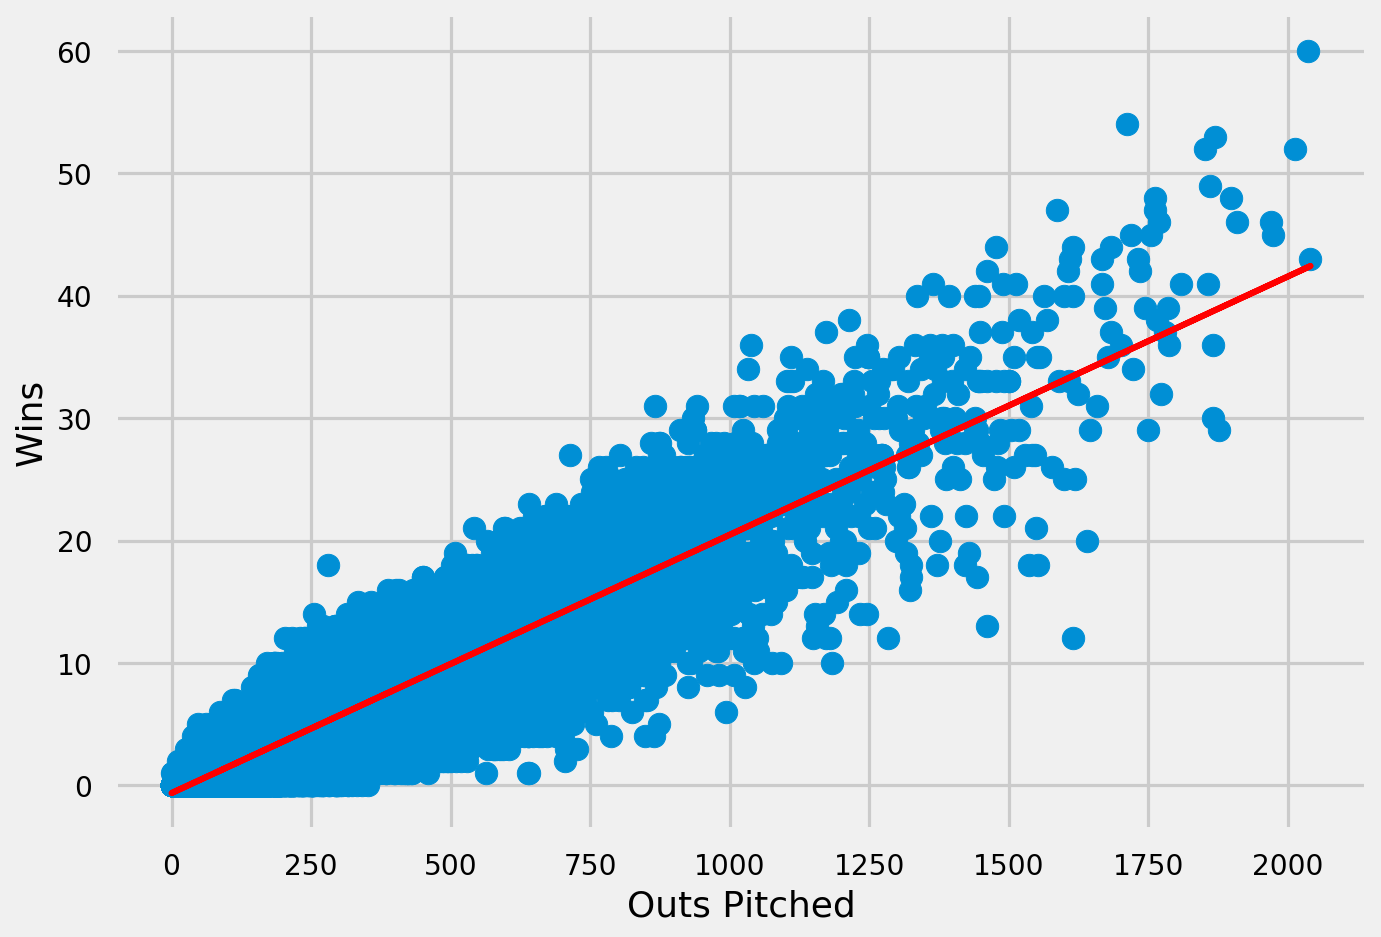

In [8]:
plt.xlabel('Outs Pitched')
plt.ylabel('Wins')
x = pitching['IPouts']
y = pitching['W']
plt.scatter(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")

In [9]:
correlation(pitching['IPouts'], pitching['W'])

0.9345152011889937

Unsurprisingly, there's a very strong correlation between outs pitched and wins - for one thing, a pitcher must pitch at least 5 innings to record a win.

### Games Started vs. Wins

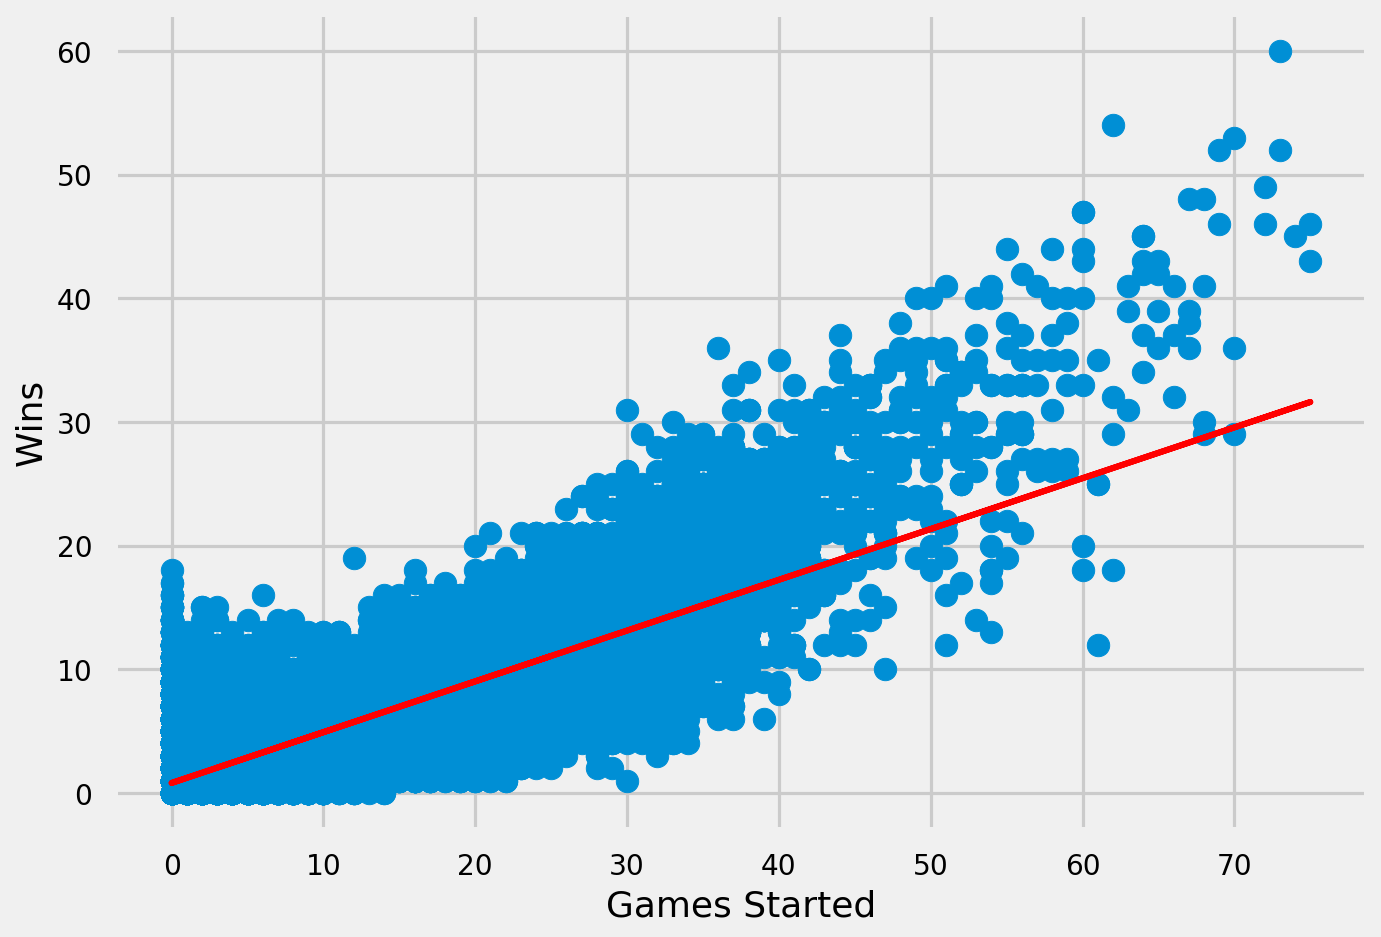

In [10]:
plt.xlabel('Games Started')
plt.ylabel('Wins')
x = pitching['GS']
y = pitching['W']
plt.scatter(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")

Also not terribly surprising: starting pitchers are more likely to record wins in baseball.

### Wins vs. Strikeouts

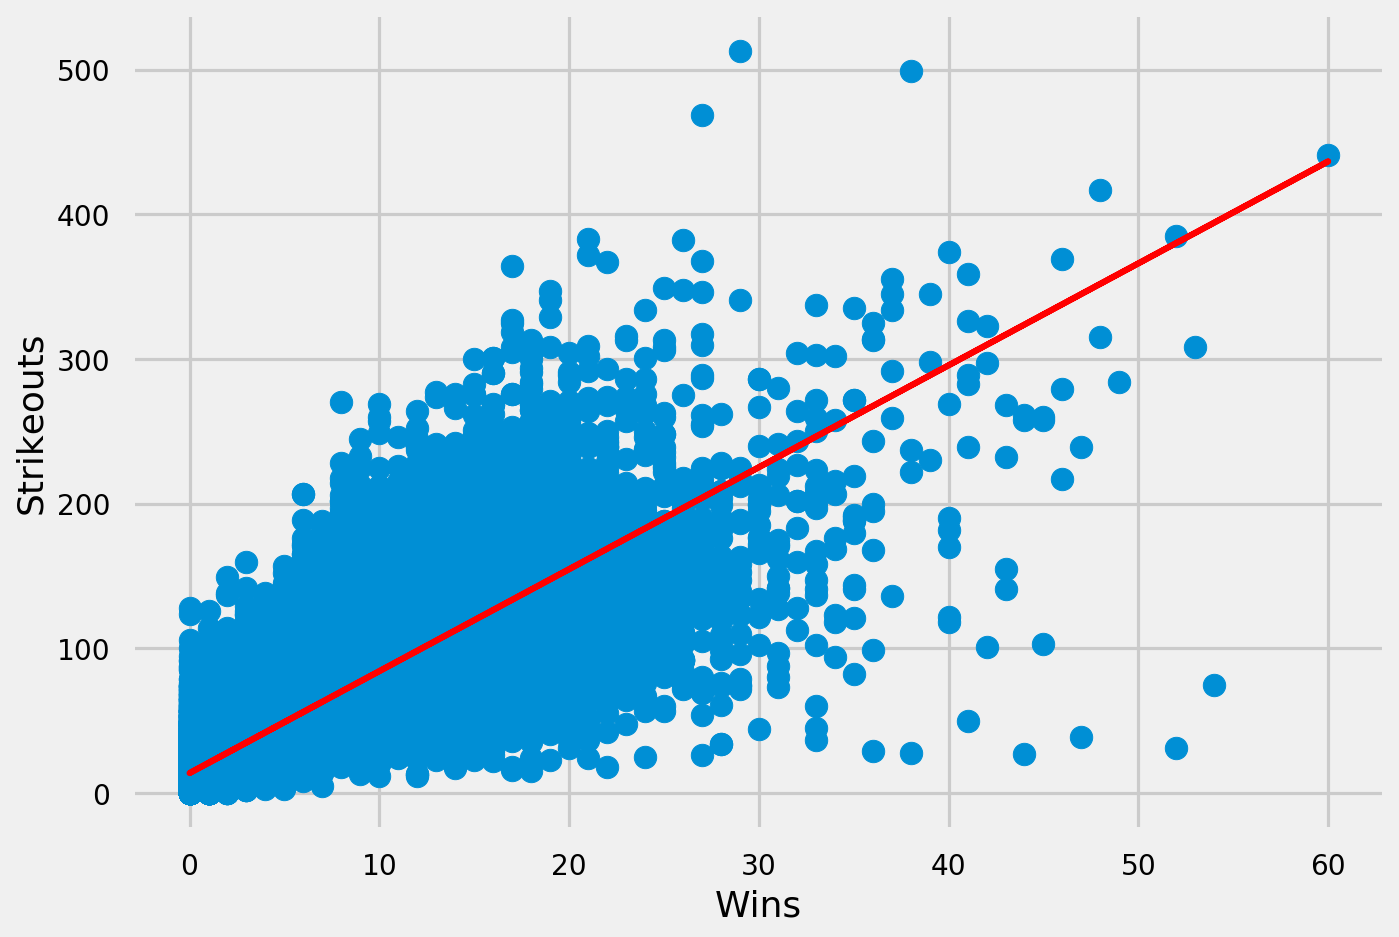

In [11]:
plt.xlabel('Wins')
plt.ylabel('Strikeouts')
x = pitching['W']
y = pitching['SO']
plt.scatter(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")

In [12]:
correlation(pitching['W'], pitching['SO'])

0.821822997935493

Outs pitched, wins, and games started are all statistics that have a direct relationship, so let's look a bit deeper. Wins and strikeouts aren't derived from each other, but you'd expect there to be a strong correlation, and in fact there is.

## Statistics that change over time

What about statistics that have changed markedly over the years? The game of baseball has changed significantly since the late 1800s:
* Equipment - cleats, bats, and even the ball itself have changed many times over the years
* Player fitness - our understanding of nutrition, physical fitness, and training regiments have evolved (as one example, how many players were smoking in the dugouts in 2018 vs. 1908?)
* Rules - the rules have changed
* Coaching strategies - the modern pitching rotation, pitch count limits, and roster sizes have all led to changes in the game

### Games started over the years

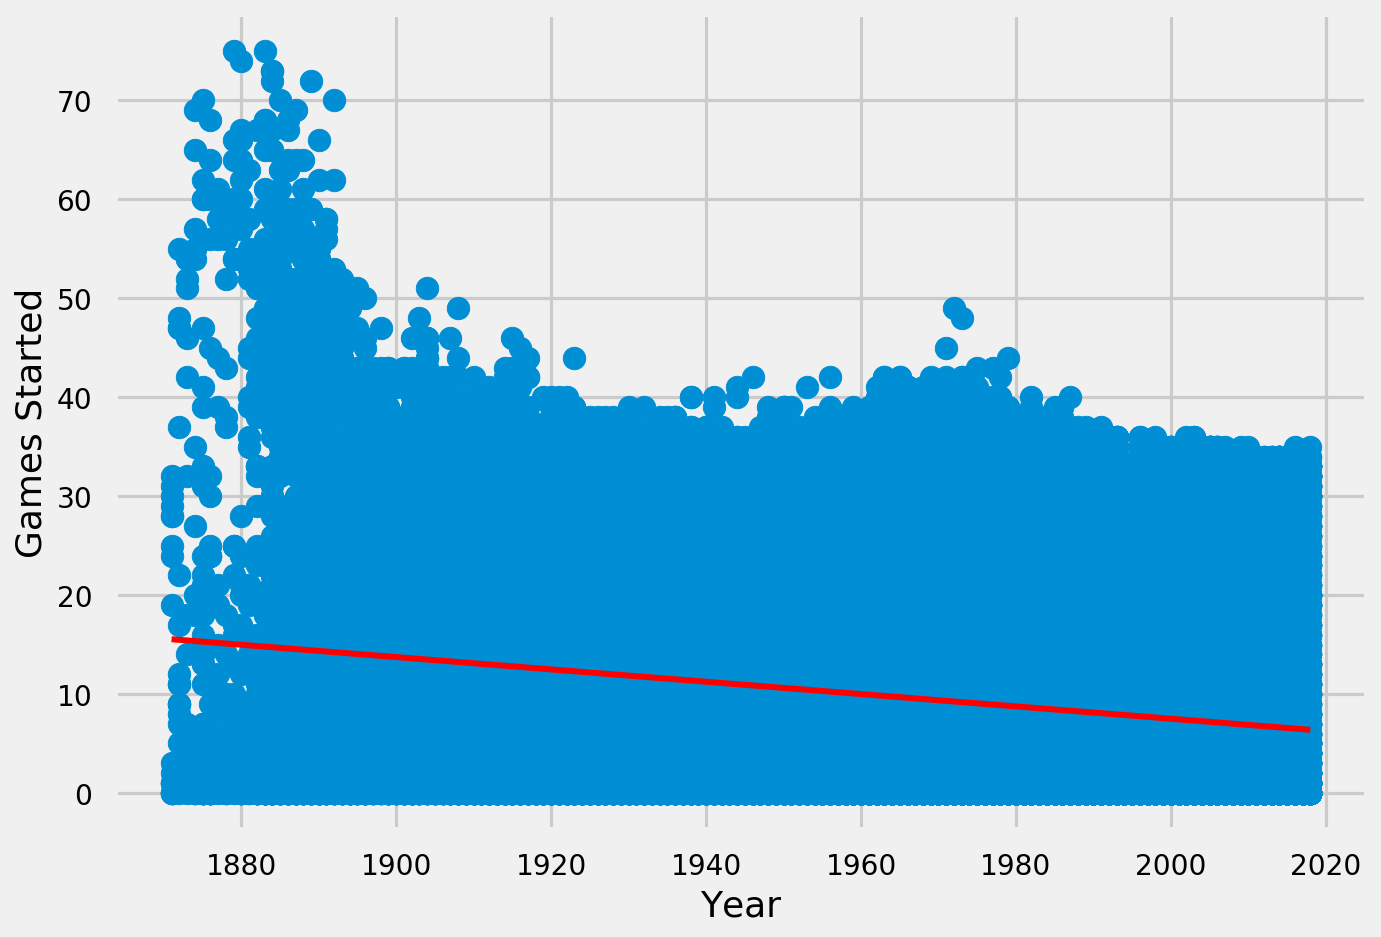

In [13]:
plt.xlabel('Year')
plt.ylabel('Games Started')
x = pitching['yearID']
y = pitching['GS']
plt.scatter(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")

No pitcher has started more than 40 games since the early 1980s, well below the 70+ games started in the 1800s. The modern four-man pitching rotation and larger rosters are responsible for this.

### Complete games over the years

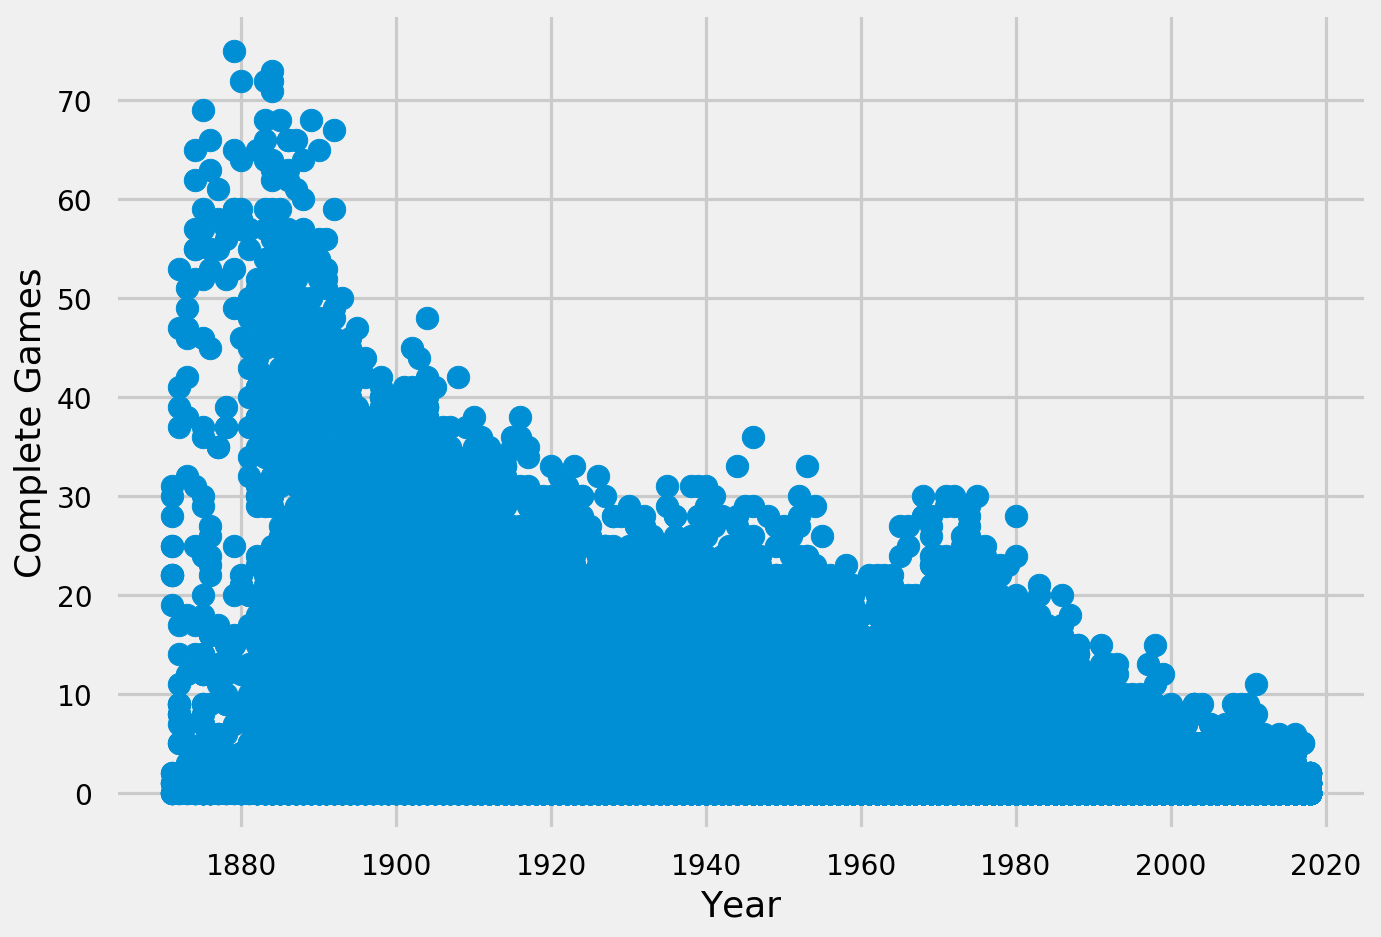

In [14]:
plt.xlabel('Year')
plt.ylabel('Complete Games')
x = pitching['yearID']
y = pitching['CG']
plt.scatter(x, y)

Naturally, fewer starts means fewer complete games, but the decline here is even more significant, likely due to increased utilization of bullpen relievers and the more recent concern about pitch counts. There's a marked decline even since 1980 in the number of complete games pitched, and nobody has pitched more then 10 in a decade.

### Saves over the years

The Save is a more recent creation. In MLB a save goes to the relief pitcher if:

* He is the finishing pitcher in a game won by his team;
* He is not the winning pitcher;
* He is credited with at least ⅓ of an inning pitched; and
* He satisfies one of the following conditions:
  * He enters the game with a lead of no more than three runs and pitches for at least one inning
  * He enters the game, regardless of the count, with the potential tying run either on base, at bat or on deck
  * He pitches for at least three innings.

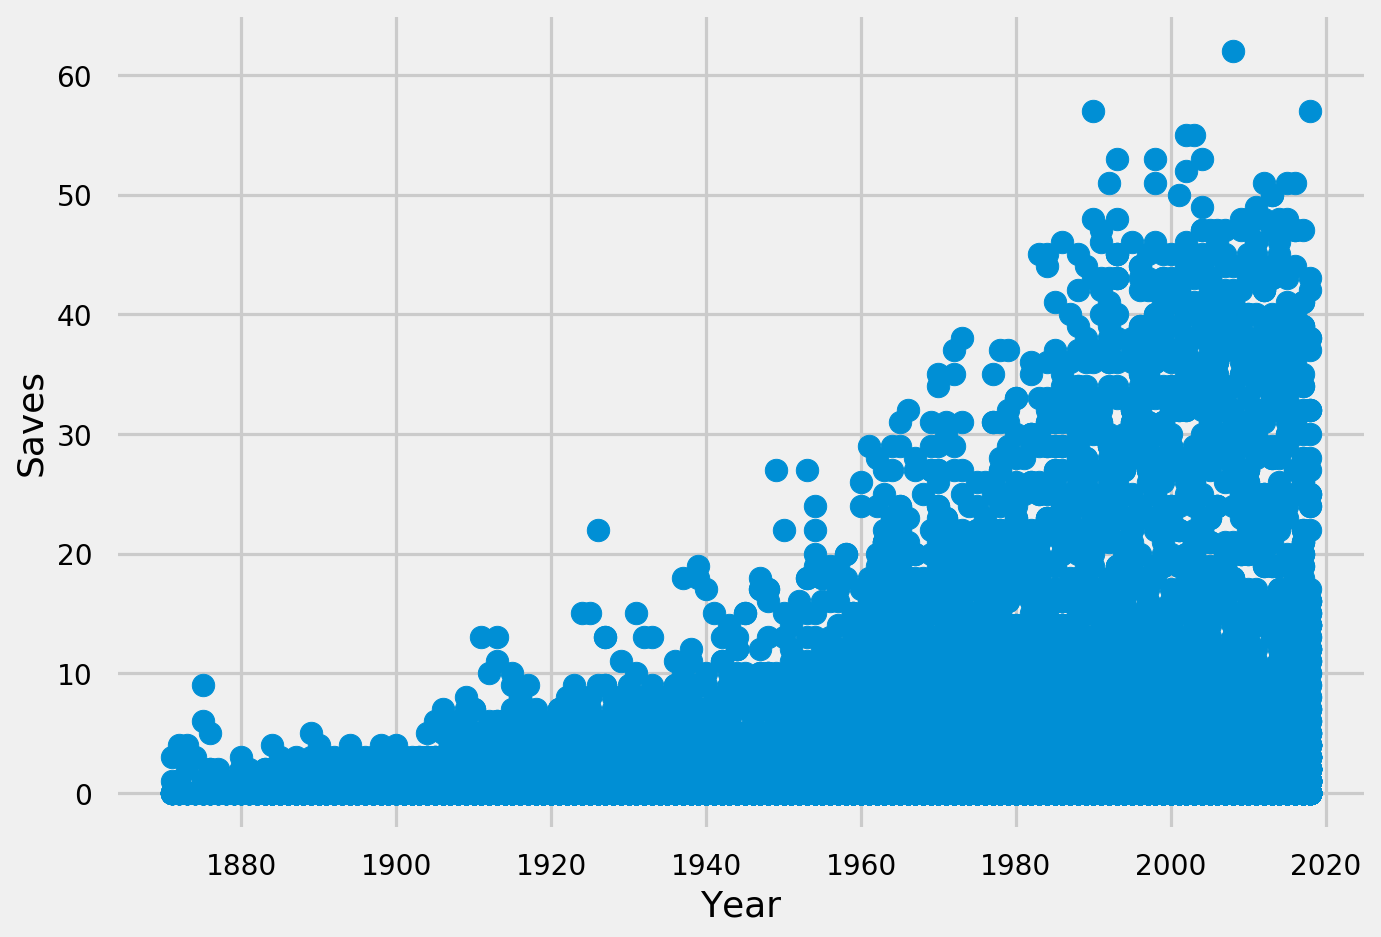

In [15]:
plt.xlabel('Year')
plt.ylabel('Saves')
x = pitching['yearID']
y = pitching['SV']
plt.scatter(x, y)

I was suprised to see that Saves go back to the 1800s since it is pretty much a modern creation. It looks Lahman's has retroactively generated save statistics, which is fascinating. Not surprisingly, relief pitchers and especially closers are a modern phenomenon, so the number of saves per pitcher has increased over the years, especially over the last 35 years as the Save has become an integral aspect of the game.

### Hit by pitch ("plunking") over the years

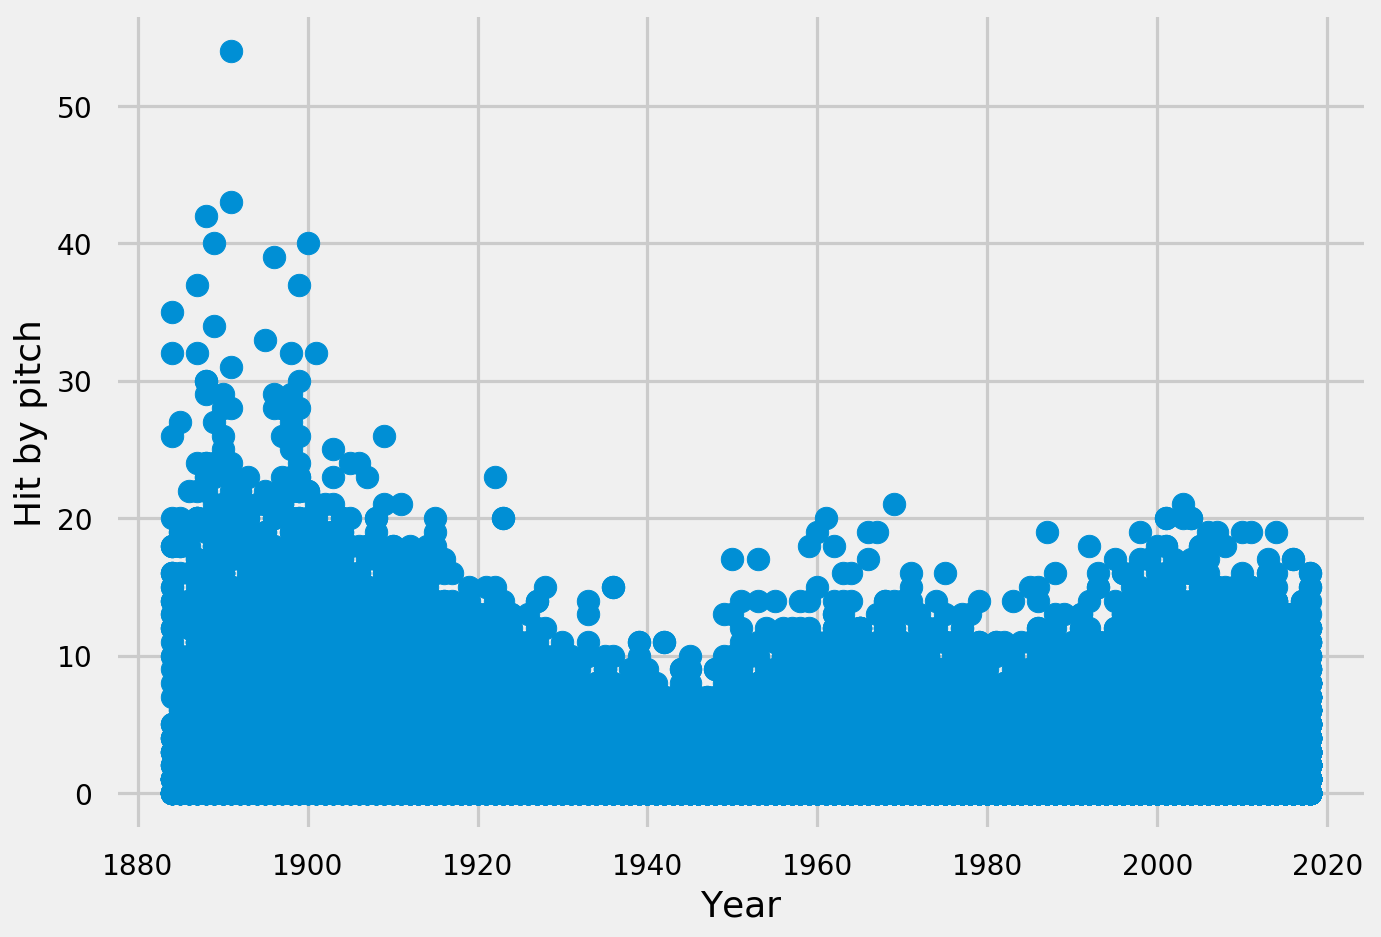

In [16]:
plt.xlabel('Year')
plt.ylabel('Hit by pitch')
x = pitching['yearID']
y = pitching['HBP']
plt.scatter(x, y)

When a pitcher hits (or "plunks") a batter with the ball, the batter takes first base just as if he'd walked. The pitcher is penalized with an HBP (hit by pitch) and the runner is earned. I was curious to see how HBP had changed over the years. 

When you first glance at this scatterplot, you might assume pitchers hit fewer batters today than they did at the turn of the 20th century. However, remember that pitchers in the 1800s pitched more games and faced more batters than they do in the modern era. To really get a sense of HBP trends we need to normalize it by the number of batters faced.

When looking at ratios, it's a good idea to filter out outliers who have a small sample size. For example, if a pitcher only faced 2 batters in a season and hit one of them, we don't want his 0.5 in our analysis since most pitchers faced hundreds of batters in a season. So let's only look at pitchers who faced at least 100 that season.

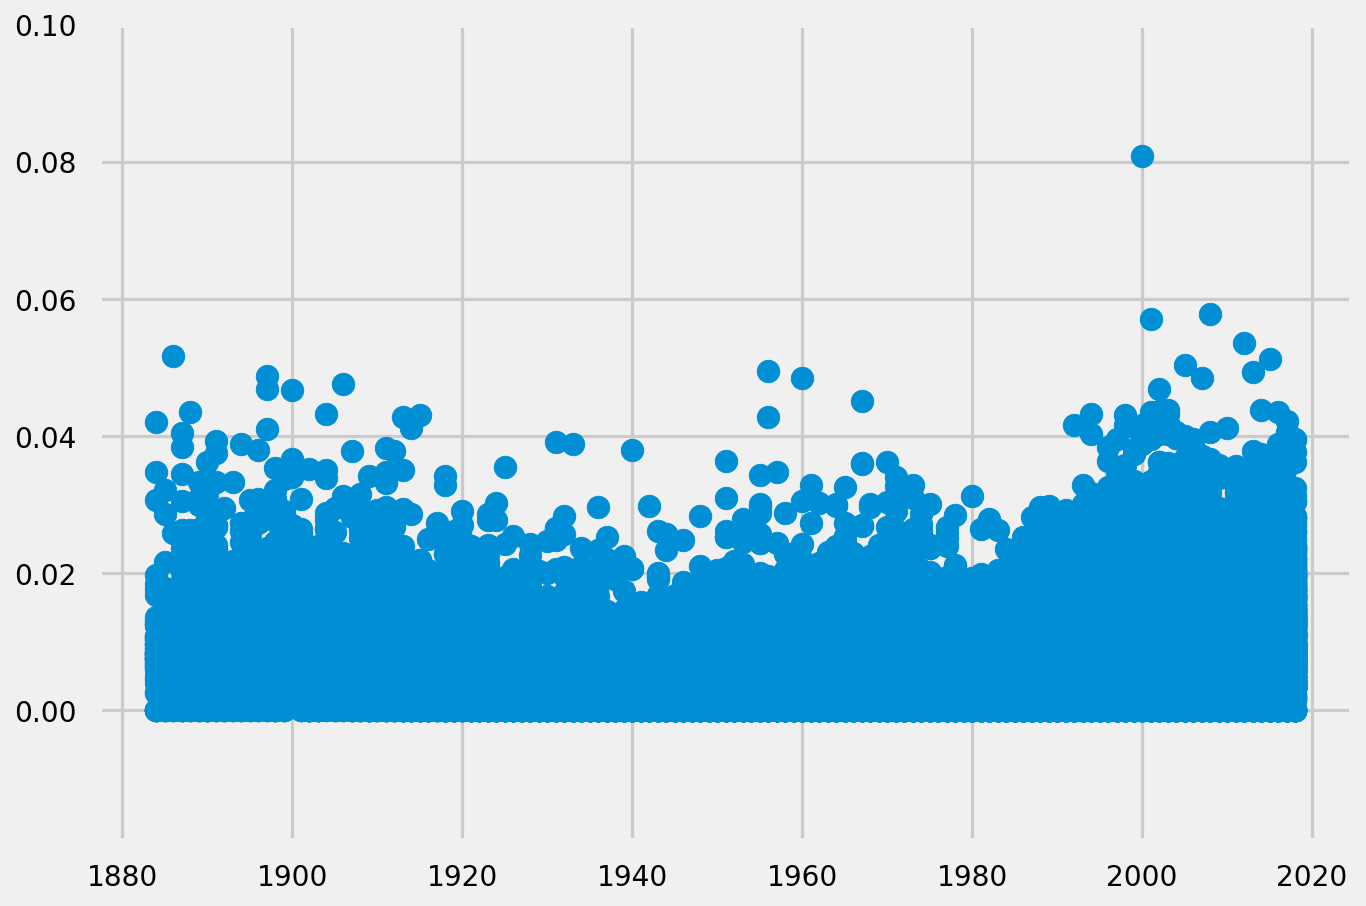

In [17]:
df = pitching.dropna(subset=['HBP', 'BFP'])
df = df[df['BFP'] > 100]
x = df['yearID']
y = df['HBP'] / df['BFP']
plt.scatter(x, y)

Wait, what's that strange outlier near the year 2000?

First, the ratio of HBP to batters faced is going to continue to come in useful, so let me add it directly to the dataframe. I'm calling it the `Plunk_Ratio`.

In [18]:
df['Plunk_Ratio'] = df['HBP'] / df['BFP']

In [19]:
df.loc[df['Plunk_Ratio'] > 0.08]

,playerID,yearID,stint,teamID,lgID,W,L,G,GS,CG,SHO,SV,IPouts,H,ER,HR,BB,SO,BAOpp,ERA,IBB,WP,HBP,BK,BFP,GF,R,SH,SF,GIDP,Plunk_Ratio
33138,hershor01,2000,1,LAN,NL,1,5,10,6,0,0,0,74,42,36,5,14,13,0.389,13.14,1.0,2,11.0,0,136.0,1,36,0.0,3.0,4.0,0.080882


In [20]:
people.loc[people['playerID'] == 'hershor01']

,playerID,birthYear,birthMonth,birthDay,birthCountry,birthState,birthCity,deathYear,deathMonth,deathDay,deathCountry,deathState,deathCity,nameFirst,nameLast,nameGiven,weight,height,bats,throws,debut,finalGame,retroID,bbrefID
7812,hershor01,1958.0,9.0,16.0,USA,NY,Buffalo,NaN,NaN,NaN,NaN,NaN,NaN,Orel,Hershiser,Orel Leonard,190.0,75.0,R,R,1983-09-01,2000-06-26,herso001,hershor01


Okay so Cy Young award winner Orel Hershiser is our outlier! He plunked 11 batters in 2000 having only faced 136. That was the last year of his career, and he only started 6 games.

Earlier I calculated the Plunk Ratio when I charted, but since earlier I added the handy column `Plunk_Ratio` I can just use that in my plotting.

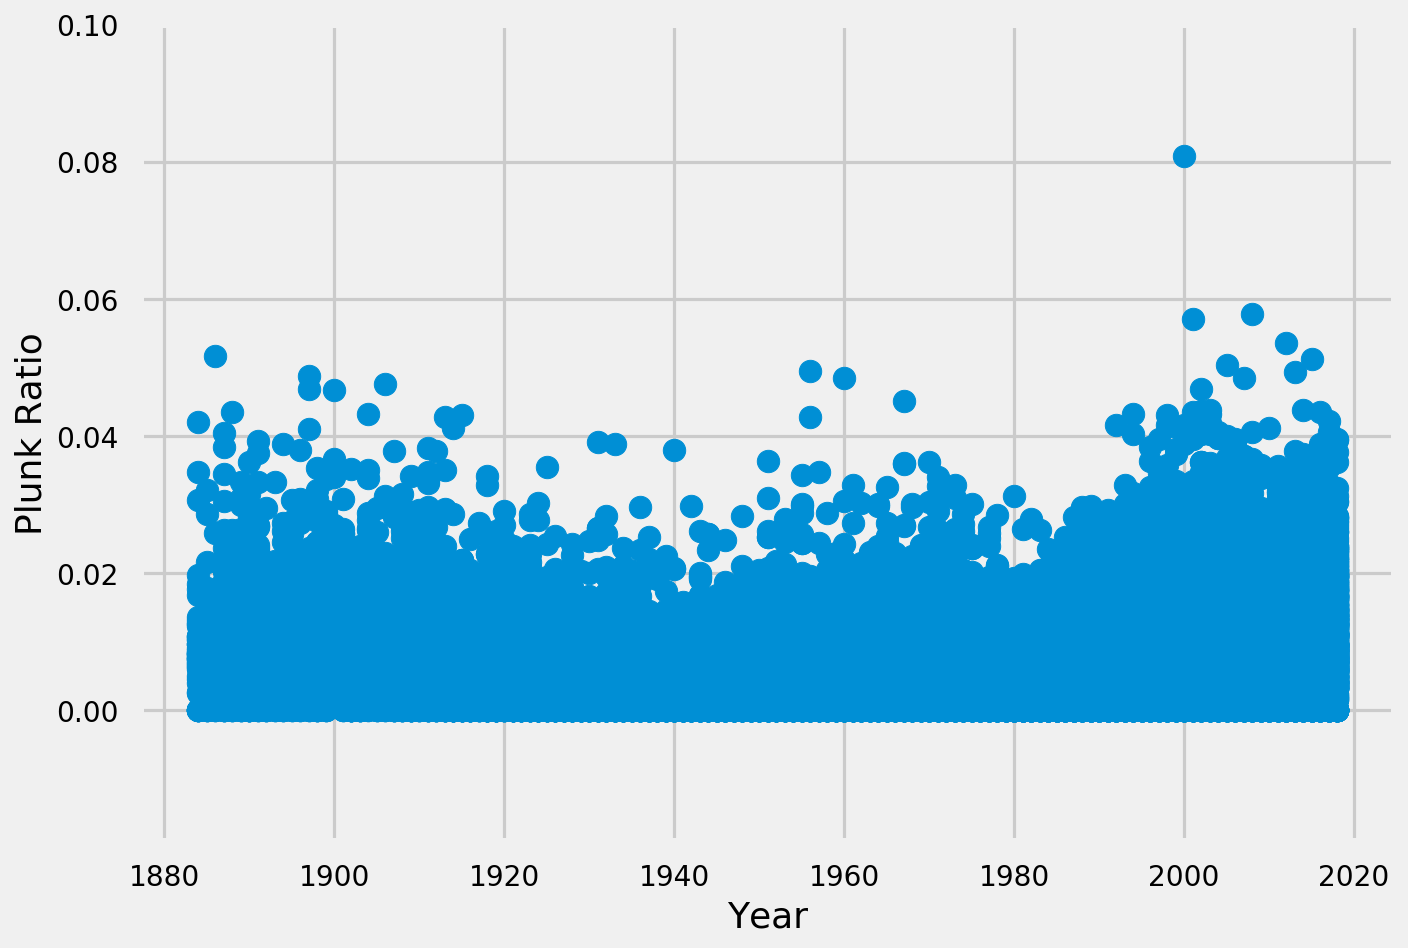

In [21]:
plt.xlabel('Year')
plt.ylabel('Plunk Ratio')
x = df['yearID']
y = df['Plunk_Ratio']
plt.scatter(x, y)

It's interesting that pitchers' Plunk Ratios declined in the period around WWII.

(array([1.1459e+04, 9.2210e+03, 5.6460e+03, 2.7670e+03, 1.5820e+03,
        6.5400e+02, 3.1700e+02, 1.6400e+02, 7.4000e+01, 4.6000e+01,
        3.1000e+01, 7.0000e+00, 6.0000e+00, 1.0000e+00, 2.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([0.        , 0.00404412, 0.00808824, 0.01213235, 0.01617647,
        0.02022059, 0.02426471, 0.02830882, 0.03235294, 0.03639706,
        0.04044118, 0.04448529, 0.04852941, 0.05257353, 0.05661765,
        0.06066176, 0.06470588, 0.06875   , 0.07279412, 0.07683824,
        0.08088235]),
 <a list of 20 Patch objects>)

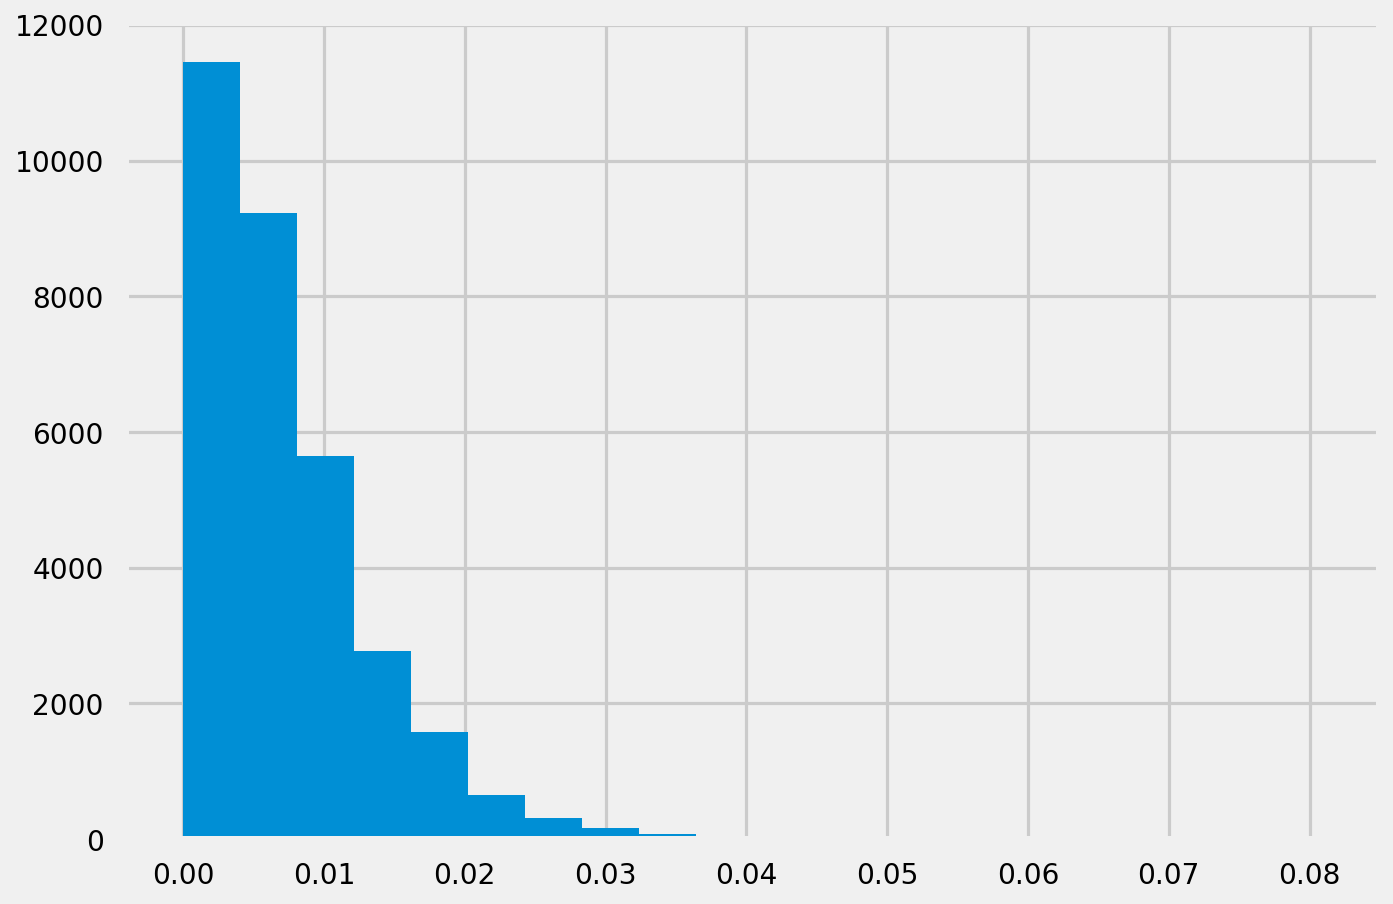

In [22]:
plt.hist(y, bins=20)

The dataset includes a pitching value called `stint` which reflects the order of appearances in a season. In a pitching rotation, your "ace" usually is your first starter, followed by your second best starter, etc. I was curious if there's any relationship between `Plunk_Ratio` and stint. One hypothesis is that harder throwers are more likely to hit batters, and harder throwers are more likely to be aces.

In [23]:
pitching.stint.unique()

array([1, 2, 3, 4, 5])

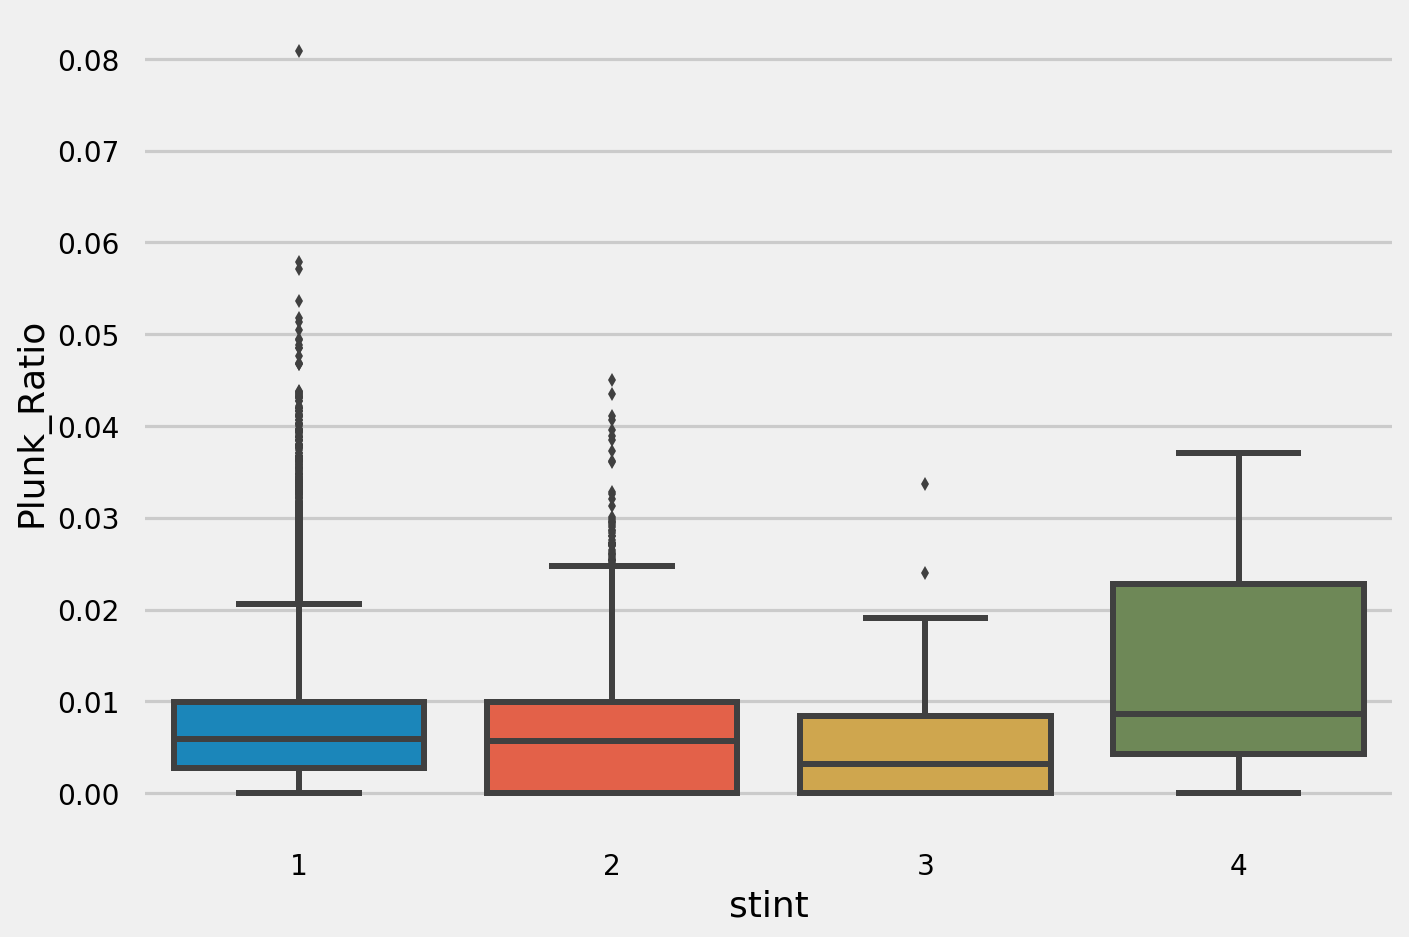

In [24]:
sns.boxplot(x="stint", y="Plunk_Ratio", data=df)

We can also look at the relationship between strikeouts and HBPs. As we can see, there is a relationship, and pitchers that strike out more batters are more likely to hit batters.

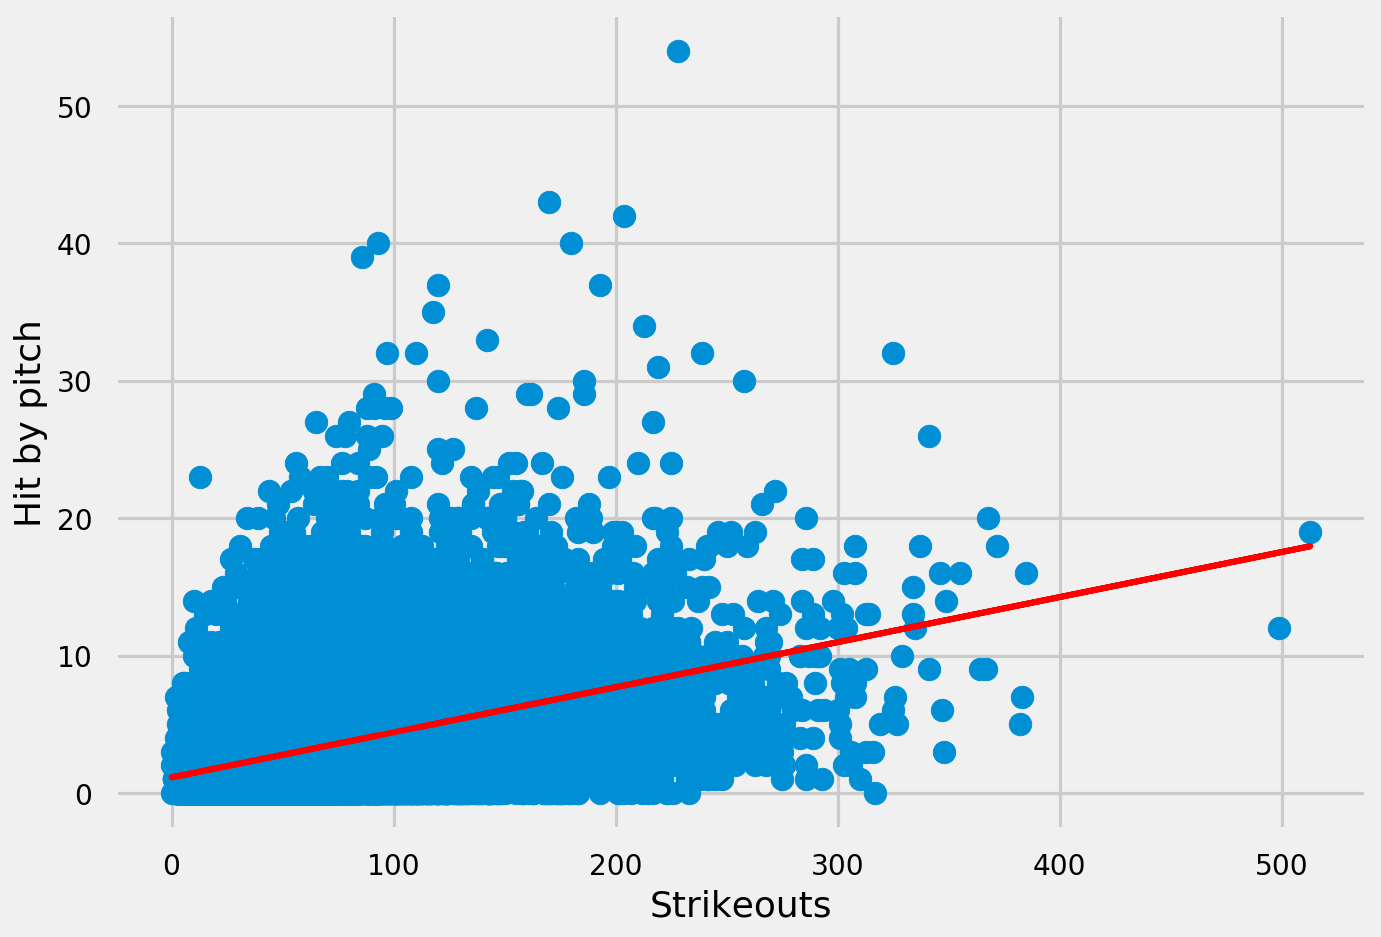

In [25]:
plt.xlabel('Strikeouts')
plt.ylabel('Hit by pitch')
x = df['SO']
y = df['HBP']
plt.scatter(x, y)
z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r-")

In [26]:
correlation(pitching['SO'], pitching['HBP'])

0.572213549679118